# TO DO BEFORE PREPRINT
- add to data folder
    - add sex and species masks
    - add sex and species segmentations if used
    - add sex and species segmentation labels if used
    - decide how much raw vs processed data we want to include
        - raw + TransformFiles: add transformix plus step here in notebook
        - raw + instructions + summary adjjac for m+f, r+m
        - just summary adjjacs
- make paths relative, not hard-coded

# imports

In [1]:
import os, sys, time
import tifffile as tif
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import csv

from scipy import ndimage
import scipy.stats as st
import seaborn as sns

# Define functions

In [2]:
def get_all_values_above_zero(volumes_in):
    volumes_out = np.ravel([volumes_in])
    volumes_out = volumes_out[volumes_out>0]

    return volumes_out

In [3]:
def make_magnitude_array(inputarray):
    outputarray = np.sqrt(np.square(inputarray[:,:,:,0])+np.square(inputarray[:,:,:,1])+np.square(inputarray[:,:,:,2]))
    return outputarray

In [4]:
def group_jacobians( vol_list,grp1,grp2,mask,reg_vol_name,save_info):
    grp1_adjjac_vols = []
    grp2_adjjac_vols = []
    grp1_med = []
    grp2_med = []
    grp1_jac_vols = []
    grp2_jac_vols = []

    for i in np.arange(len(vol_list)):
        fld = os.path.join(src,"output_dirs/{}_in_{}".format(vol_list[i],reg_vol_name))
        jac = tif.imread(os.path.join(fld,"spatialJacobian.tif"))
        medjac = np.median(jac)
        print(medjac)
        adjjac = (jac/medjac)*(mask/255)
        if vol_list[i] in grp1:
            print("adding {} to grp1".format(vol_list[i]))
            grp1_med.append(medjac)
            grp1_jac_vols.append(jac)
            grp1_adjjac_vols.append(adjjac)
        else:
            print("adding {} to grp2".format(vol_list[i]))
            grp2_med.append(medjac)
            grp2_jac_vols.append(jac)
            grp2_adjjac_vols.append(adjjac)
    print('calculating group values for plots')
    grp1_jac_vals = get_all_values_above_zero(grp1_jac_vols)
    grp2_jac_vals = get_all_values_above_zero(grp2_jac_vols)
    grp1_adjjac_vals = get_all_values_above_zero(grp1_adjjac_vols)
    grp2_adjjac_vals = get_all_values_above_zero(grp2_adjjac_vols)
    if len(save_info) > 0:
        try: 
            save_dir = save_info[0]
            save_nm_1 = save_info[1]
            save_nm_2 = save_info[2]
            tif.imsave(os.path.join(save_dir,"{}_jac_median.tif".format(save_nm_1)),np.median(grp1_jac_vols,axis=0))
            tif.imsave(os.path.join(save_dir,"{}_adjjac_median.tif".format(save_nm_1)),np.median(grp1_adjjac_vols,axis=0))
            tif.imsave(os.path.join(save_dir,"{}_jac_median.tif".format(save_nm_2)),np.median(grp2_jac_vols,axis=0))
            tif.imsave(os.path.join(save_dir,"{}_jadjac_median.tif".format(save_nm_2)),np.median(grp2_adjjac_vols,axis=0))
        except: 
            print('not saving, error in save_dir, should have three strings [save_dir, save_nm_1, save_nm_2] and instead has: {}'.format(save_info))
    returned_data=[grp1_med, grp1_jac_vals, grp1_adjjac_vals, grp2_med, grp2_jac_vals, grp2_adjjac_vals]
    print('finished gathering group data')
    return returned_data

In [6]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"
sex_mask  = tif.imread(os.path.join(src,'tiffs/PRA_mask.tif'))
f002_grid = np.zeros(np.shape(sex_mask))

zl,yl,xl=np.shape(f002_grid)
gridsz=20

for xval in np.arange(0,int((xl-(xl%gridsz))/20)):
    f002_grid[:,:,xval*20]=1
for yval in np.arange(0,int((yl-(yl%gridsz))/20)):
    f002_grid[:,yval*20,:]=1
for zval in np.arange(0,int((zl-(zl%gridsz))/20)):
    f002_grid[zval*20,:,:]=1


In [4]:
# make a list of all the volumes
#manually change the # in line 11
#grp1 = ["f110","t107","f002","f003"]
#grp2 = ["a235","e106","c514","k320"]
grp1=['tom1','tom2','tom3','tom4','tom5','tom6','tom7','tom8']
grp2=['f110','t107','f002','f003','a235','e106','c514','k320']
grp1n=len(grp1)
grp2n=len(grp2)
vol_list = grp1+grp2

# User inputs

In [9]:
# set a base directory where your folders live
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"

# set mask and volume names for each set of data
sex_mask  = tif.imread(os.path.join(src,'tiffs/PRA_mask.tif'))
sex_reg_vol_name = "PRA"

species_mask  = tif.imread(os.path.join(src,'tiffs/matlas_mask.tif'))
species_reg_vol_name = "matlas"

# choose colors for plots (must be matplotlib compatible)
colorf='limegreen'
colorm='lightskyblue'
colormof='green'
colormom='skyblue'
colormo='hotpink'
colorra='orange'

In [10]:
# make a list of all the volumes in their groups
grpf = ["f110","t107","f002","f003"]
grpm = ["a235","e106","c514","k320"]

grpmof=['tom1','tom2','tom3','tom4']
grpmom=['tom5','tom6','tom7','tom8']

grpmo=grpmof+grpmom
grpra=grpf+grpm

species_vol_list = grpmo+grpra
sex_vol_list = grpf+grpm

# net jacobians

In [11]:
rat_sex_returned_data = group_jacobians(sex_vol_list,grpf,grpm,sex_mask,sex_reg_vol_name,['/home/emilyjanedennis/Desktop/','rat_f','rat_m'])
[grpf_med, grpf_jac_vals, grpf_adjjac_vals, grpm_med, grpm_jac_vals, grpm_adjjac_vals]=rat_sex_returned_data

3.1282816
adding f110 to grp1
3.0053854
adding t107 to grp1
2.6321685
adding f002 to grp1
2.51804
adding f003 to grp1
3.5597515
adding a235 to grp2
3.9444325
adding e106 to grp2
3.9164927
adding c514 to grp2
2.761043
adding k320 to grp2
calculating group values for plots
finished gathering group data


In [12]:
mouse_sex_returned_data = group_jacobians(grpmo,grpmof,grpmom,species_mask,species_reg_vol_name,[])
[grpmof_med, grpmof_jac_vals, grpmof_adjjac_vals, grpmom_med, grpmom_jac_vals, grpmom_adjjac_vals]=mouse_sex_returned_data

5.158715
adding tom1 to grp1
3.56534
adding tom2 to grp1
4.6647367
adding tom3 to grp1
2.857313
adding tom4 to grp1
3.2531793
adding tom5 to grp2
4.46053
adding tom6 to grp2
4.1874638
adding tom7 to grp2
3.8880866
adding tom8 to grp2
calculating group values for plots
finished gathering group data


In [13]:
species_returned_data = group_jacobians(species_vol_list,grpmo,grpra,species_mask,species_reg_vol_name,[])
[grpmo_med, grpmo_jac_vals, grpmo_adjjac_vals, grpra_med, grpra_jac_vals, grpra_adjjac_vals]=species_returned_data

5.158715
adding tom1 to grp1
3.56534
adding tom2 to grp1
4.6647367
adding tom3 to grp1
2.857313
adding tom4 to grp1
3.2531793
adding tom5 to grp1
4.46053
adding tom6 to grp1
4.1874638
adding tom7 to grp1
3.8880866
adding tom8 to grp1
2.69221
adding f110 to grp2
2.5692337
adding t107 to grp2
2.2396712
adding f002 to grp2
2.1512392
adding f003 to grp2
3.1251633
adding a235 to grp2
3.4251492
adding e106 to grp2
3.5551023
adding c514 to grp2
2.391899
adding k320 to grp2
calculating group values for plots
finished gathering group data


# Plotting aggregate data

### rat sex data

In [ ]:
fig, axs= plt.subplots(2,sharex=True)
fig.suptitle('RAT RAW DATA')
axs[0].set_title('rat sex medians as ticks')
axs[0].scatter(grpf_med,np.ones(np.shape(grpf_med)),marker='|',color=colorf,alpha=0.5)
axs[0].scatter(grpm_med,np.ones(np.shape(grpm_med)),marker='|',color=colorm,alpha=0.5)
axs[1].set_title('all voxels across all brains in group plotted as histogram')
axs[1].hist(grpf_jac_vals,edgecolor=colorf,color='w',alpha=0.5,bins=20)
axs[1].hist(grpm_jac_vals,edgecolor=colorm,color='w',alpha=0.5,bins=20)
plt.show()

In [37]:
f002_test=tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/f002_in_PRA/spatialJacobian.tif')

Text(0.5, 1.0, 'before adjustment, all jacobian values for all voxels')

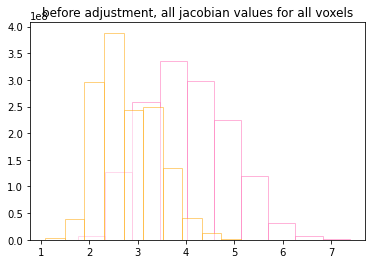

In [11]:
plt.hist(grp1_jac_vals,edgecolor='hotpink',color='w',alpha=0.5)
plt.hist(grp2_jac_vals,edgecolor='orange',color='w',alpha=0.5)
plt.title('before adjustment, all jacobian values for all voxels')

Text(0.5, 1.0, 'after adjustment, all jacobian values for all voxels')

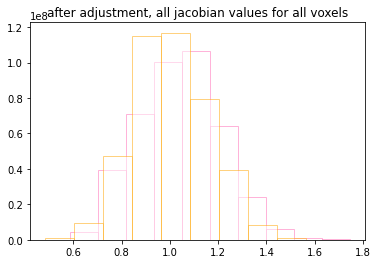

In [12]:
fig, axs= plt.subplots(2,sharex=True)
fig.suptitle('F002 EXAMPLE DATA')
axs[0].set_title('median as tick')
axs[0].scatter(f002_med,1,marker='|',color=colorf,alpha=0.5)
axs[1].set_title('all voxels across f002 plotted as histogram')
axs[1].hist(f002_jac_vals,edgecolor=colorf,color='w',alpha=0.5,bins=20)
plt.savefig('/home/emilyjanedennis/Desktop/f002_withtick.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

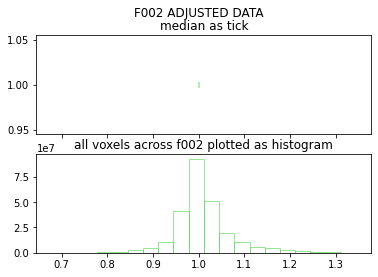

In [42]:
fig, axs= plt.subplots(2,sharex=True)
fig.suptitle('F002 ADJUSTED DATA')
axs[0].set_title('median as tick')
axs[0].scatter(1,1,marker='|',color=colorf,alpha=0.5)
axs[1].set_title('all voxels across f002 plotted as histogram')
axs[1].hist(f002_adjjac_vals,edgecolor=colorf,color='w',alpha=0.5,bins=20)
plt.savefig('/home/emilyjanedennis/Desktop/f002_adj_withtick.eps')

In [15]:
fig, axs= plt.subplots(2,sharex=True)
fig.suptitle('RAT RAW DATA')
axs[0].set_title('rat sex medians as ticks')
axs[0].scatter(grpf_med,np.ones(np.shape(grpf_med)),marker='|',color=colorf,alpha=0.5)
axs[0].scatter(grpm_med,np.ones(np.shape(grpm_med)),marker='|',color=colorm,alpha=0.5)
axs[1].set_title('all voxels across all brains in group plotted as histogram')
axs[1].hist(grpf_jac_vals,edgecolor=colorf,color='w',alpha=0.5,bins=20)
axs[1].hist(grpm_jac_vals,edgecolor=colorm,color='w',alpha=0.5,bins=20)
plt.savefig('/home/emilyjanedennis/Desktop/sexdata_withticks.eps')

tom1
tom2
tom3
tom4
tom5
tom6
tom7
tom8
f110
t107
f002
f003
a235
e106
c514
k320


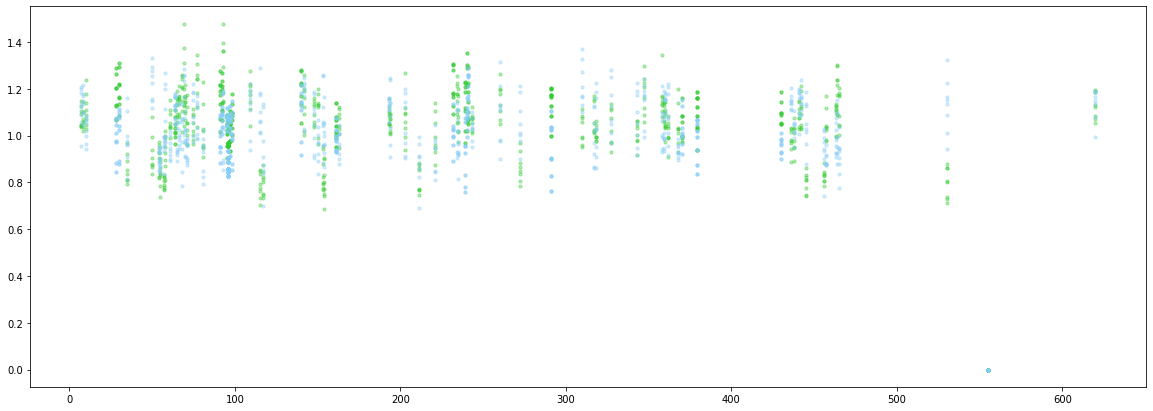

In [16]:
fig, axs= plt.subplots(2,sharex=True)
fig.suptitle('species medians as ticks, all voxels plotted as histograms')
fig.suptitle('RAW DATA')
axs[0].set_title('species medians as ticks')
axs[0].scatter(grpmo_med,np.ones(np.shape(grpmo_med)),marker='|',color=colormo,alpha=0.5)
axs[0].scatter(grpra_med,np.ones(np.shape(grpra_med)),marker='|',color=colorra,alpha=0.5)
axs[1].set_title('all voxels across all brains in group plotted as histogram')
axs[1].hist(grpmo_jac_vals,edgecolor=colormo,color='w',alpha=0.5,bins=20)
axs[1].hist(grpra_jac_vals,edgecolor=colorra,color='w',alpha=0.5,bins=20)
plt.savefig('/home/emilyjanedennis/Desktop/species_data_withticks.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

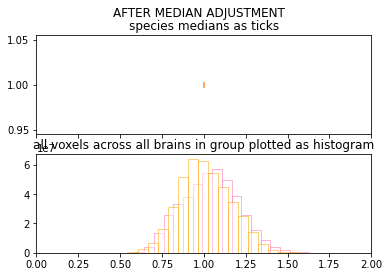

In [22]:
fig, axs= plt.subplots(2,sharex=True)
fig.suptitle('AFTER MEDIAN ADJUSTMENT')
axs[0].set_title('species medians as ticks')
axs[0].scatter(np.ones(np.shape(grpmo_med)),np.ones(np.shape(grpmo_med)),marker='|',color=colormo,alpha=0.1)
axs[0].scatter(np.ones(np.shape(grpra_med)),np.ones(np.shape(grpra_med)),marker='|',color=colorra,alpha=0.1)
axs[1].set_title('all voxels across all brains in group plotted as histogram')
axs[1].hist(grpmo_adjjac_vals,edgecolor=colormo,color='w',alpha=0.5,bins=20)
axs[1].hist(grpra_adjjac_vals,edgecolor=colorra,color='w',alpha=0.5,bins=20)
plt.xlim([0,2])
plt.savefig('/home/emilyjanedennis/Desktop/species_data_afteradj_withticks.eps')

# Plots by region

# TODO 
clear large variables that we will no longer use, then load vols from saved locations

In [20]:
allen_ann_in_matlas = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/Allen_annotation_in_matlas_90um_edge_90um_vent_erosion.tif')
sigma_ann_in_matlas = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/sigma_ann_in_matlas.tif')
sigma_ann_in_PRA = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_in_PRAm_seed4.tif')
sigma_labels = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_in_PRA.csv')
sigma_labels = sigma_labels.drop(columns=['Unnamed: 0'])
allen_labels = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/allen_with_voxels.csv')

In [12]:
df = sigma_labels.copy()
adjjac_by_region = {}
for idx in sigma_labels.index:
    sigma_ann_in_matlas[sigma_ann_in_matlas==int(sigma_labels.ID[idx])]=int(sigma_labels.praid[idx])

# for each animal, get avg jac PER REGION
for i in np.arange(0,len(vol_list)):
    # get animal name
    animal = vol_list[i]
    print(animal)
    # get adjjac vals
    if animal in grp1:
        adjjac_vol = grp1_adjjac_vols[i]
    else:
        adjjac_vol = grp2_adjjac_vols[i-grp1n]      
    # insert a column for this animal into the df
    df.insert(2,animal,np.nan)
    # segment by region
    for idx in df.index:
        df.at[idx,animal] = np.median(adjjac_vol[sigma_ann_in_matlas==int(df.praid[idx])])
    

f110


/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


t107
f002
f003
a235
e106
c514
k320


In [16]:
df[df.common_name == 'pretectum']

,atlas,ID,k320,c514,e106,a235,f003,f002,t107,f110,name,common_name,label,praid,structure_id_path
94,Waxholm,481,0.861806,1.160553,1.22303,1.187869,0.950827,0.908877,1.023704,1.032272,pretectal_region,pretectum,Pretectal Region,318,/0/37/59/91/12/313/318
95,Waxholm,482,0.861806,1.160553,1.22303,1.187869,0.950827,0.908877,1.023704,1.032272,pretectal_region,pretectum,Pretectal Region,318,/0/37/59/91/12/313/318


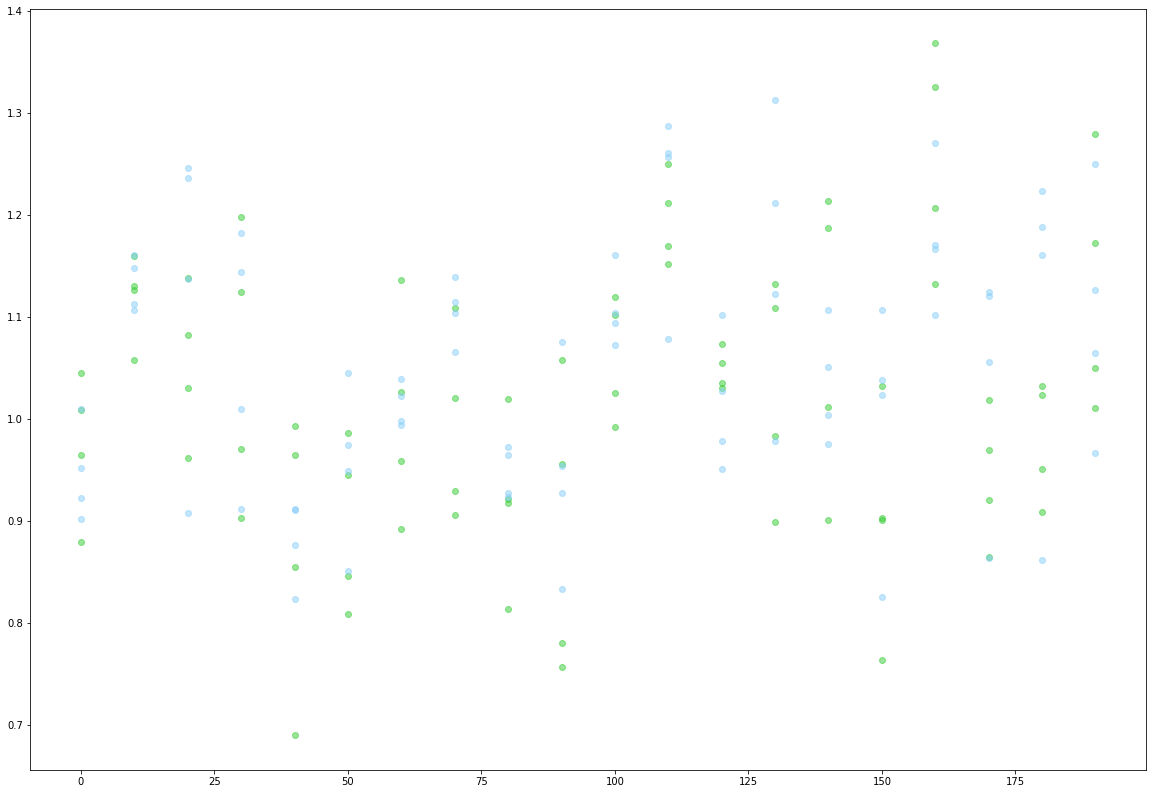

In [29]:
idx_list = []
list_praids_to_keep=np.unique(df.praid)[40:60]

for praid in list_praids_to_keep:
    idx_list.append(df[df.praid==praid].index[0])

sub_df = df.copy()
sub_df = sub_df.loc[idx_list]
grp1_subset = sub_df[grp1].to_numpy()
grp2_subset = sub_df[grp2].to_numpy()


plt.figure(figsize=(20,14))
for i in np.arange(0,len(idx_list)):
    plt.scatter(np.ones(len(grp1_subset[0,:]))*10*i,grp1_subset[i,:],c='limegreen',alpha=0.5) #hotpink limegreen
    plt.scatter(np.ones(len(grp2_subset[0,:]))*10*i,grp2_subset[i,:],c='lightskyblue',alpha=0.5) #orange lightskyblue
plt.show()

In [50]:
?tstdf.drop_duplicates

In [52]:
tstdf = df.copy()[['praid']+vol_list]
tstdf=tstdf.drop_duplicates(subset="praid")
tstdf

,praid,f110,t107,f002,f003,a235,e106,c514,k320
0,150,0.890354,0.836912,1.036060,0.923124,1.068137,0.970921,0.965740,1.001228
2,232,0.958773,0.891500,1.136004,1.026593,0.998319,0.994252,1.022306,1.039400
4,109,0.938322,0.977375,1.109493,1.155679,1.218180,1.193332,1.175631,1.133562
6,347,0.993046,1.018492,1.239760,1.212126,1.153748,1.175281,1.170604,1.192489
8,66,1.023323,1.003904,0.940893,0.981273,0.993174,1.056791,1.141193,0.960103
...,...,...,...,...,...,...,...,...,...
224,10,1.073667,1.051694,0.943167,1.020425,0.998681,1.082159,1.063221,0.961771
226,58,1.218977,1.200652,0.975003,0.998036,1.063842,1.115413,1.265356,0.969293
228,163,1.008193,0.964828,0.879355,1.044827,0.951942,0.921862,0.901609,1.009671
230,211,0.964386,0.992895,0.689764,0.855136,0.876455,0.910291,0.911916,0.822962


In [58]:
melted_df=pd.melt(tstdf,id_vars=["praid"],value_vars=vol_list,var_name='animal',value_name='median_jac')

In [60]:
melted_df.insert(2,'group',0)
for idx in melted_df.index:
    if melted_df.animal[idx] in grp1:
        melted_df.group[idx]=1
    else:
        melted_df.group[idx]=2

/tmp/ipykernel_479149/1897233772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_df.group[idx]=1
/tmp/ipykernel_479149/1897233772.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_df.group[idx]=2


In [63]:
melted_df

,praid,animal,group,median_jac
0,150,f110,0,0.890354
1,232,f110,0,0.958773
2,109,f110,0,0.938322
3,347,f110,0,0.993046
4,66,f110,0,1.023323
...,...,...,...,...
667,10,k320,1,0.961771
668,58,k320,1,0.969293
669,163,k320,1,1.009671
670,211,k320,1,0.822962


In [68]:
melted_df.median_jac=melted_df.median_jac.fillna(0)

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
linear_regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
X=melted_df[['praid','median_jac']]
y=melted_df.group
linear_regression=LinearRegression()
linear_regression.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
y_pred=linear_regression.predict(X)

AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [81]:
y_pred

array([0.48499684, 0.49539181, 0.49012273, 0.50222169, 0.49985702,
       0.49407847, 0.50852491, 0.49010457, 0.50119693, 0.50697682,
       0.47316019, 0.4907124 , 0.4887592 , 0.50229127, 0.51007475,
       0.47910155, 0.52245189, 0.48939951, 0.47918162, 0.4812363 ,
       0.48720937, 0.48650032, 0.53767373, 0.48824194, 0.49976983,
       0.38203723, 0.50037072, 0.38194942, 0.48813613, 0.51911761,
       0.48790328, 0.50476794, 0.49992797, 0.49540688, 0.49883718,
       0.50651277, 0.48268906, 0.49427494, 0.47798749, 0.48641224,
       0.51874197, 0.52735235, 0.48065545, 0.49044749, 0.48513426,
       0.49855249, 0.50586172, 0.54852643, 0.5191648 , 0.49705054,
       0.48976396, 0.49480094, 0.48097559, 0.5149043 , 0.52251161,
       0.51652968, 0.54758822, 0.52646457, 0.49049322, 0.51349249,
       0.50524943, 0.53112435, 0.51317514, 0.49989361, 0.49577898,
       0.49853273, 0.5178031 , 0.51955097, 0.5246327 , 0.53334465,
       0.50229981, 0.52825496, 0.51584332, 0.53431165, 0.48994

In [15]:
# get the net (fem - mal or mus - rattus) jac for EACH REGION 

# get median grp1, grp2 brains
grp1_med_matrix = np.median(grp1_adjjac_vols,axis=0)
grp2_med_matrix = np.median(grp2_adjjac_vols,axis=0)

net_brain = np.subtract(grp1_med_matrix,grp2_med_matrix)

In [16]:
df.insert(2,'net_brain_jacs',np.nan)
# segment by region
for idx in df.index:
        df.at[idx,'net_brain_jacs'] = np.nanmedian(net_brain[sigma_ann_in_matlas==int(df.praid[idx])])
df    

/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


atlas    ID  net_brain_jacs      k320      c514      e106      a235  \
0     Tohoku    11       -0.079112  1.001228  0.965740  0.970921  1.068137   
1     Tohoku    12       -0.079112  1.001228  0.965740  0.970921  1.068137   
2     Tohoku    21        0.013132  1.039400  1.022306  0.994252  0.998319   
3     Tohoku    22        0.013132  1.039400  1.022306  0.994252  0.998319   
4     Tohoku    31       -0.142286  1.133562  1.175631  1.193332  1.218180   
..       ...   ...             ...       ...       ...       ...       ...   
229  Waxholm  1152        0.047322  1.009671  0.901609  0.921862  0.951942   
230  Waxholm  1161        0.017082  0.822962  0.911916  0.910291  0.876455   
231  Waxholm  1162        0.017082  0.822962  0.911916  0.910291  0.876455   
232    SIGMA  1171             NaN       NaN       NaN       NaN       NaN   
233    SIGMA  1172             NaN       NaN       NaN       NaN       NaN   

         f003      f002      t107      f110  \
0    0.923124  1.036060  0.836912  0.890354   
1    0.923124  1.036060  0.836912  0.890354   
2    1.026593  1.136004  0.891500  0.958773   
3    1.026593  1.136004  0.891500  0.958773   
4    1.155679  1.109493  0.977375  0.938322   
..        ...       ...       ...       ...   
229  1.044827  0.879355  0.964828  1.008193   
230  0.855136  0.689764  0.992895  0.964386   
231  0.855136  0.689764  0.992895  0.964386   
232       NaN       NaN       NaN       NaN   
233       NaN       NaN       NaN       NaN   

                                     name                 common_name  \
0    agranular_dysgranular_insular_cortex              insular_cortex   
1    agranular_dysgranular_insular_cortex              insular_cortex   
2                agranular_insular_cortex    agranular_insular_cortex   
3                agranular_insular_cortex    agranular_insular_cortex   
4                amygdalohyppocampic_area  amygdalohippocampal_cortex   
..                                    ...                         ...   
229        ventral_hippocampal_commissure      hippocampal_commissure   
230                  periventricular_grey      periventricular_region   
231                  periventricular_grey      periventricular_region   
232                    ventricular_system         ventricular_systems   
233                    ventricular_system         ventricular_systems   

                                    label  praid     structure_id_path  
0    Agranular Dysgranular Insular Cortex    150          /0/37/59/150  
1    Agranular Dysgranular Insular Cortex    150          /0/37/59/150  
2                Agranular Insular Cortex    232      /0/37/59/150/232  
3                Agranular Insular Cortex    232      /0/37/59/150/232  
4                Amygdalohyppocampic Area    109         /0/37/567/109  
..                                    ...    ...                   ...  
229        Ventral Hippocampal Commissure    163  /0/37/59/104/579/163  
230                  Periventricular Grey    211    /0/37/59/91/11/211  
231                  Periventricular Grey    211    /0/37/59/91/11/211  
232                    Ventricular System      3                  /0/3  
233                    Ventricular System      3                  /0/3  

[234 rows x 16 columns]

In [17]:
order_rows = np.argsort(np.asarray(df.net_brain_jacs.copy()))

y=df.net_brain_jacs.copy()[order_rows]
x=df.common_name.copy()[order_rows]

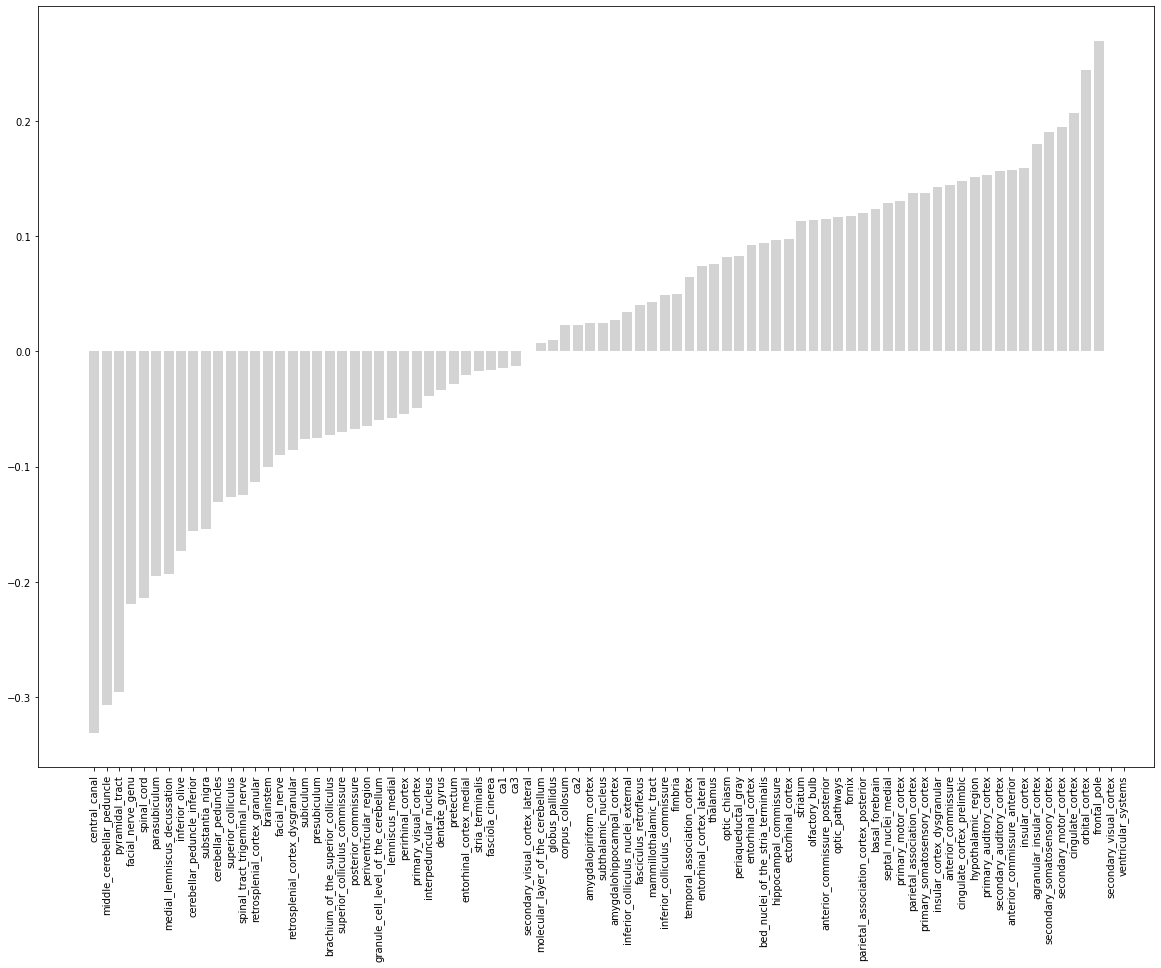

In [18]:
plt.figure(figsize=(20,14))
plt.bar(x,y,color='lightgray')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='net_brain_jacs', ylabel='common_name'>

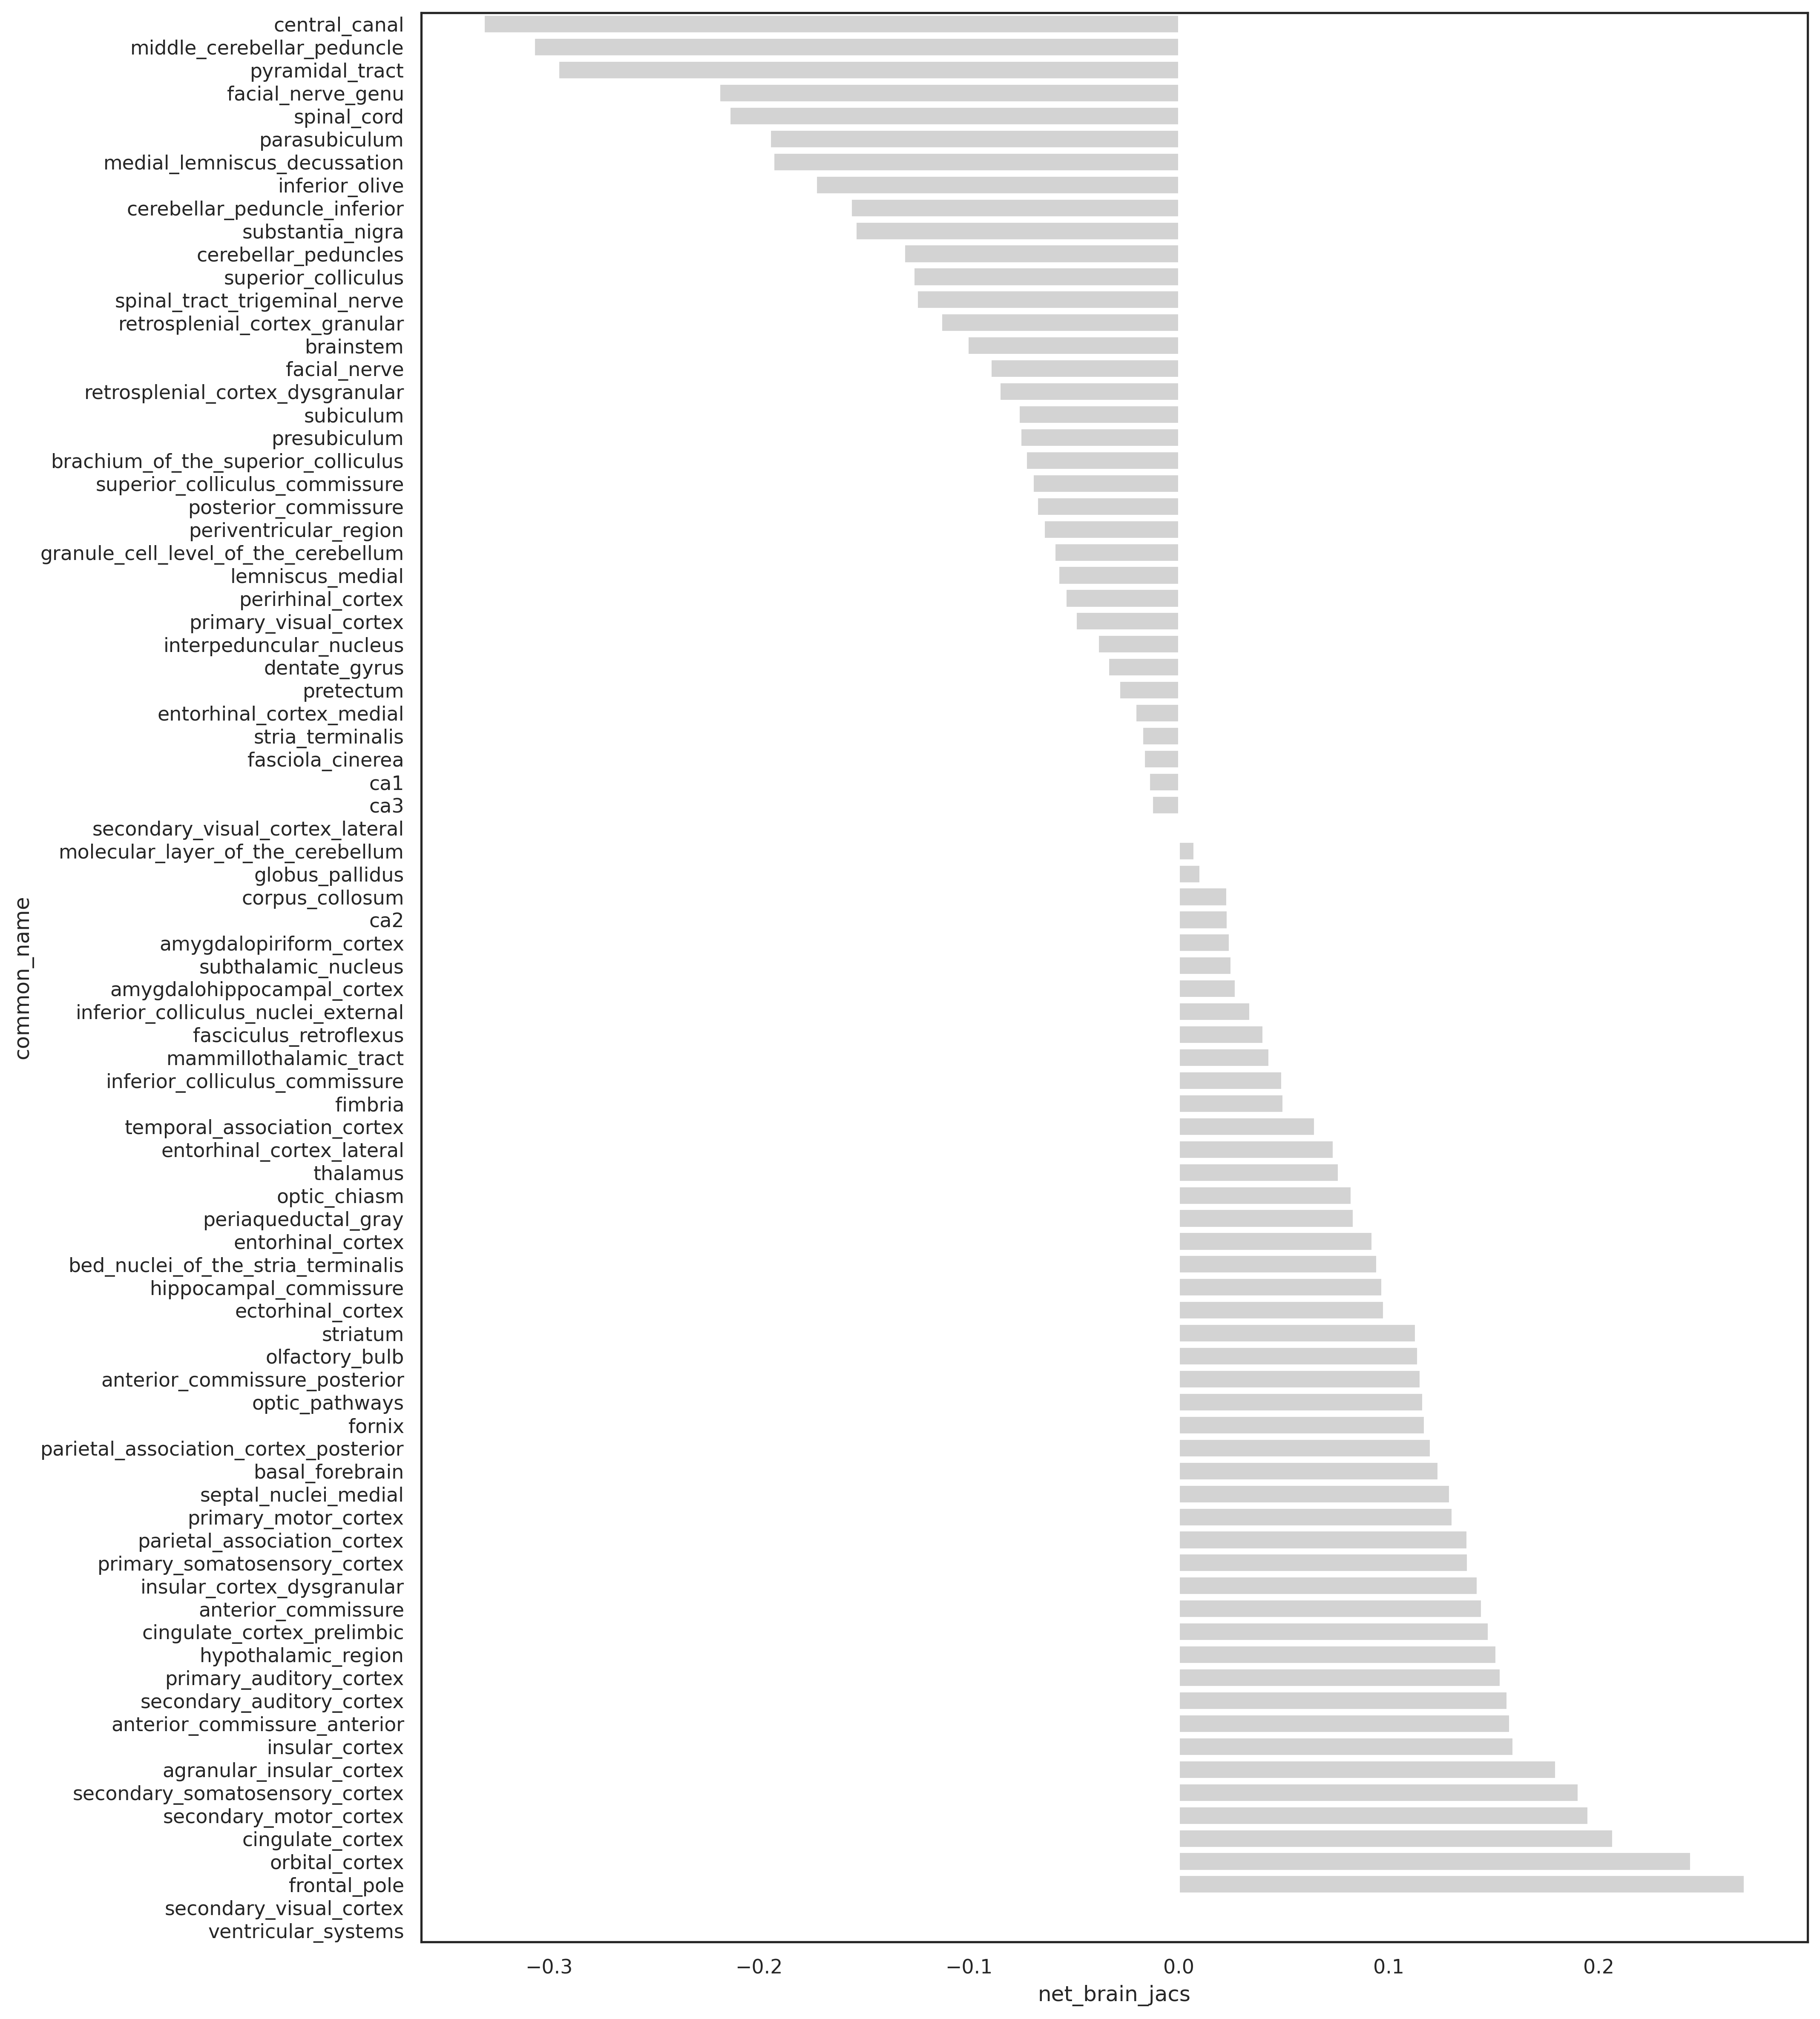

In [34]:
plt.figure(figsize=(14, 20), dpi=300)
sns.set(font_scale=1,style='white')
sns.barplot(x=y,y=x,orient='horizontal',color='lightgray')

/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


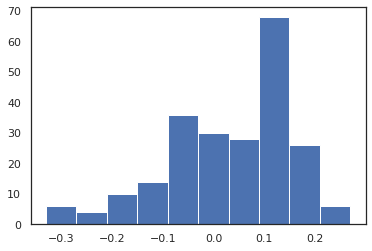

In [35]:
plt.hist(y)
plt.show()

In [ ]:
# LATER want to color by praid, using
colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)
cell_rainbow

In [ ]:
plt.scatter(df.praid,df.net_brain_jacs)

# Geometric displacements

In [17]:
for i in np.arange(len(vol_list)):
    sqrtaffinebrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_{}_affine/deformationField.tif".format(vol_list[i],reg_vol_name))))
    sqrtfullbrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_{}/deformationField.tif".format(vol_list[i],reg_vol_name))))
    netbrain = sqrtfullbrain - sqrtaffinebrain
    if vol_list[i] in grp_1:
        print("adding {} to grp1".format(vol_list[i]))
        grp_1_netdefo.append(netbrain)
    else:
        print("adding {} to grp2 vols".format(vol_list[i]))
        grp_2_netdefo.append(netbrain)

adding f110 to female vols
adding t107 to female vols
adding f002 to female vols
adding f003 to female vols
adding k320 to male_vols
adding k321 to male_vols
adding k323 to male_vols
adding k327 to male_vols


# stopped working here 

In [18]:
i=4
sqrtaffinebrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_PRA_affine/deformationField.tif".format(vol_list[i]))))
sqrtfullbrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_PRAf_seed4/deformationField.tif".format(vol_list[i]))))
netbrain = sqrtfullbrain - sqrtaffinebrain
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/k320_affine_mag.tif",sqrtaffinebrain)
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/k320_full_mag.tif",sqrtfullbrain)
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/k320_net_mag.tif",netbrain)

In [19]:
netdefo_PRA = np.median(mascsd,0) - np.median(femsd,0)
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/netdefo_PRA.tif",netdefo_PRA)

In [207]:
mtest = np.median(mascs,0)
netjac_PRAf = test-mtest
tif.imsave('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/netjac_PRAf.tif',netjac_PRAf)

In [8]:
avgjac_f_in_f = tif.imread(os.path.join(src,'tiffs/avgjac_f_PRAf.tif'))
avgjac_f_in_m = tif.imread(os.path.join(src,'tiffs/avgjac_f_PRAm.tif'))
avgjac_m_in_f = tif.imread(os.path.join(src,'tiffs/avgjac_m_PRAf.tif'))
avgjac_m_in_m = tif.imread(os.path.join(src,'tiffs/avgjac_m_PRAm.tif'))

In [16]:
# 2021-03-05 stopped here -- waiting on elastix/transformix of labeled volume to m_matlas_alt space
netjac_PRAf = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/netjac_PRAf.tif')

In [20]:
whs_m = tif.imread(os.path.join(src,'tiffs/WHS_in_PRAm_seed4.tif'))
whs_f = tif.imread(os.path.join(src,'tiffs/WHS_in_PRAf_seed4.tif'))
whs_labs = pd.read_csv(os.path.join(src,'labels/whs_with_parents.csv'))
sigma_m = tif.imread(os.path.join(src,'tiffs/SIGMA_in_PRAm_seed4.tif'))
sigma_f = tif.imread(os.path.join(src,'tiffs/SIGMA_in_PRAf_seed4.tif'))
sigma_labs = pd.read_csv(os.path.join(src,'labels/sigma_with_parents.csv'))

In [24]:
for i in np.unique(sigma_labs['id']):
    if np.isreal(i):
        if i%2 ==0:
            print(i)
            meanval=np.mean(netjac_PRAf[(sigma_f==i) | (sigma_f==i-1)])
            sigma_f = np.where(sigma_f == i, meanval,sigma_f)
            sigma_f = np.where(sigma_f == i-1, meanval,sigma_f)

0.0
12.0
22.0
32.0
42.0
52.0
62.0
72.0
82.0
92.0
102.0
112.0
122.0
132.0
142.0
152.0
162.0
172.0
182.0
192.0
202.0
212.0
222.0
232.0
242.0
252.0


KeyboardInterrupt: 

In [22]:
#tif.imsave('/home/emilyjanedennis/scratch/sigma_netdefo.tif',sigma_f)

In [38]:
tif.imsave('/home/emilyjanedennis/brody/ejdennis/sigma_f.tif',sigma_f)

In [37]:
tif.imsave('/home/emilyjanedennis/Desktop/sigma_f.tif',sigma_f)

In [243]:
sigma_labs.to_csv('/home/emilyjanedennis/Desktop/sigma_labs_with_jacs_PRAs.csv')

In [246]:
med_f = np.median(sigma_labs.jacval.dropna())

In [247]:
ste_f = np.std(sigma_labs.jacval.dropna())/np.sqrt(len(sigma_labs.jacval.dropna()))

(618, 1150, 355)

In [256]:
dfgrpd = sigma_labs.groupby(['common_name','pra_id','parent']).mean()
dfgrpd = dfgrpd.reset_index()

dfsub = dfgrpd[abs(dfgrpd.jacval) > (12*ste_f)]
#dfsub=dfsub[['common_name','pra_id','jacval_net_in_f']].dropna()
len(dfsub)

67

<AxesSubplot:xlabel='jacval', ylabel='common_name'>

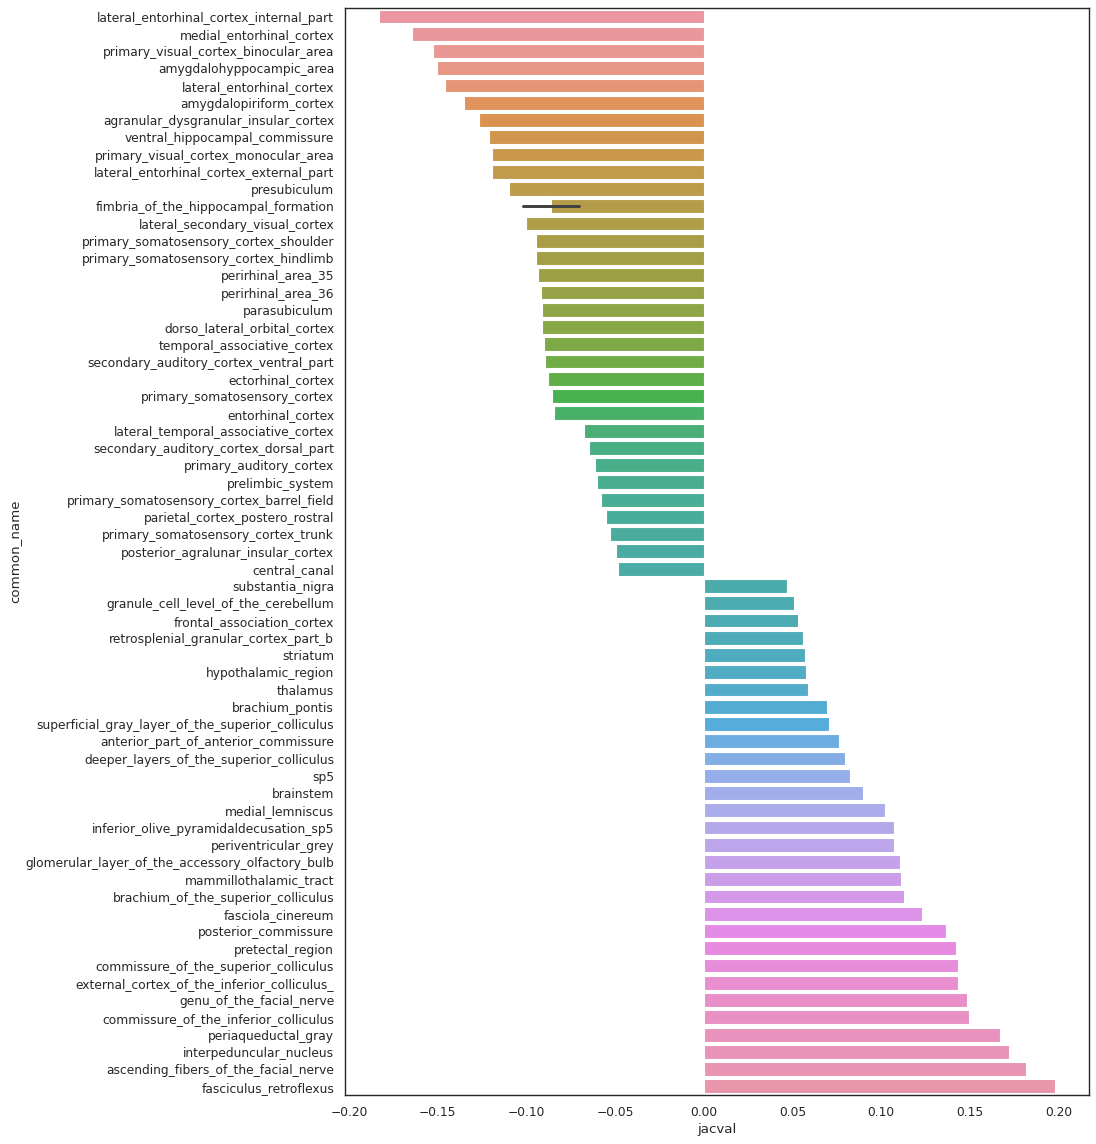

In [259]:
plt.figure(figsize=(12, 18), dpi=80)
sns.set(font_scale=1,style='white')
sns.barplot(data=dfsub.sort_values(['jacval']),x='jacval',y='common_name',orient='horizontal')

In [127]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [139]:
a=jacvals.dropna()
st.t.interval(0.995, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(-0.025072878104552616, 0.04288187544089411)

In [137]:
# also do with log transformed jacs from ea vol

/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: alpha must be between 0 and 1 inclusive

In [103]:
avgjac - 2*std

-0.24338995219192586

/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


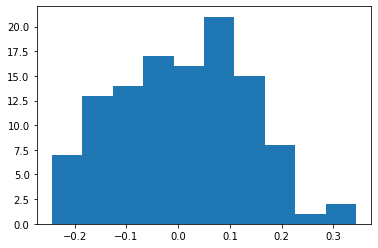

In [89]:
plt.hist(jacvals)
plt.show()

In [2]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"
vol_list= ["tom1","tom2","tom3","tom4","e106","a235","k320","c514_3"]

6

In [230]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"

fann = os.path.join(src,"tiffs/fPRA_to_PRA_net_jacobian.tif")
#fann = os.path.join(src,"output_dirs/SIGMA_in_fPRA/result.tif")
#fann_affine = os.path.join(src, "output_dirs/SIGMA_fPRA_in_PRA_affine/result.tif")
mann = os.path.join(src, "output_dirs/SIGMA_ann_in_PRA_25/result.tif")

#fann = os.path.join(src, "tiffs/WHS_ann_in_fPRA.tif")
#mann = os.path.join(src, "output_dirs/WHS_ann_in_PRA25/WHS_anns_in_PRA25.tif")

#annotationsfilename=os.path.join(src,"labels/labels_v3.csv")

annotationsfilename = os.path.join(src,"labels/SIGMA_good_labels.csv")
output= "/home/emilyjanedennis/Desktop/mf_SIGMA.tiff"
percentcsv="/home/emilyjanedennis/Desktop/mf_percent_SIGMA.csv"

## get percent of each brain for a given 'value' or label

In [231]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1,2],header=0)
print("read annotations")

read annotations


In [232]:
df=anns.dropna()
df


,atlas,ID,label
0,Tohoku,11,Agranular Dysgranular Insular Cortex
1,Tohoku,12,Agranular Dysgranular Insular Cortex
2,Tohoku,21,Agranular Insular Cortex
3,Tohoku,22,Agranular Insular Cortex
4,Tohoku,31,Amygdalohyppocampic Area
...,...,...,...
177,Waxholm,1132,Thalamus
178,Waxholm,1141,Brachium Pontis
179,Waxholm,1142,Brachium Pontis
180,Waxholm,1161,Periventricular Grey


In [233]:
df.insert(3,'fvox',0)
df.insert(4,'fvox_affine',0)
df.insert(5,'mvox',0)


In [234]:
ftiff = tif.imread(fann)
#faffinetiff = tif.imread(fann_affine)
mtiff = tif.imread(mann)
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')

In [235]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])

<ipython-input-235-01c5cdf64e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])


In [236]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
fsigmatiff = msigmatiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        fsigmatiff[fsigmatiff==i]=0

0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [237]:
np.max(fsigmatiff)

181

In [238]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() > 0.1:
        print(np.shape(fsigmatiff[fsigmatiff==i]))
        fsigmatiff[fsigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
(54968,)


<ipython-input-238-ae2ce6616ac2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() > 0.1:


1    221
Name: fvox, dtype: int16
(55343,)
2    37
Name: fvox, dtype: int16
(372549,)
3    234
Name: fvox, dtype: int16
(383733,)
4    116
Name: fvox, dtype: int16
(35191,)
5    78
Name: fvox, dtype: int16
(32045,)
6    149
Name: fvox, dtype: int16
(273770,)
7    170
Name: fvox, dtype: int16
(252711,)
8    196
Name: fvox, dtype: int16
(1323564,)
9    210
Name: fvox, dtype: int16
(1365468,)
10    271
Name: fvox, dtype: int16
(44955,)
11    289
Name: fvox, dtype: int16
(45487,)
12    174
Name: fvox, dtype: int16
(503913,)
13    165
Name: fvox, dtype: int16
(484677,)
14    178
Name: fvox, dtype: int16
(80373,)
15    170
Name: fvox, dtype: int16
(77194,)
16    234
Name: fvox, dtype: int16
(463119,)
17    243
Name: fvox, dtype: int16
(437168,)
18    236
Name: fvox, dtype: int16
(711879,)
19    244
Name: fvox, dtype: int16
(676271,)
20    117
Name: fvox, dtype: int16
(84468,)
21    378
Name: fvox, dtype: int16
(80631,)
22    74
Name: fvox, dtype: int16
(206293,)
23    178
Name: fvox, dtype: 

In [239]:
np.max(fsigmatiff)

405

In [240]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
msigmatiff= SIGMAtiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        msigmatiff[msigmatiff==i]=0


0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [241]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() < 0:
        print(np.shape(msigmatiff[msigmatiff==i]))
        msigmatiff[msigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
1    221
Name: fvox, dtype: int16
2    37
Name: fvox, dtype: int16
3    234
Name: fvox, dtype: int16
4    116
Name: fvox, dtype: int16
5    78
Name: fvox, dtype: int16
6    149
Name: fvox, dtype: int16
7    170
Name: fvox, dtype: int16
8    196
Name: fvox, dtype: int16
9    210
Name: fvox, dtype: int16
10    271
Name: fvox, dtype: int16
11    289
Name: fvox, dtype: int16
12    174
Name: fvox, dtype: int16
13    165
Name: fvox, dtype: int16
14    178
Name: fvox, dtype: int16
15    170
Name: fvox, dtype: int16
16    234
Name: fvox, dtype: int16
17    243
Name: fvox, dtype: int16
18    236
Name: fvox, dtype: int16
19    244
Name: fvox, dtype: int16
20    117
Name: fvox, dtype: int16
21    378
Name: fvox, dtype: int16
22    74
Name: fvox, dtype: int16
23    178
Name: fvox, dtype: int16
24    36
Name: fvox, dtype: int16
25    1
Name: fvox, dtype: int16
26    233
Name: fvox, dtype: int16
27    235
Name: fvox, dtype: int16
28    241
Name: fvox, dtype: int16
29 

<ipython-input-241-21cdfcfacca2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() < 0:


50    132
Name: fvox, dtype: int16
51    70
Name: fvox, dtype: int16
52    200
Name: fvox, dtype: int16
53    195
Name: fvox, dtype: int16
54    185
Name: fvox, dtype: int16
55    116
Name: fvox, dtype: int16
56    188
Name: fvox, dtype: int16
57    131
Name: fvox, dtype: int16
58    100
Name: fvox, dtype: int16
59    379
Name: fvox, dtype: int16
60    137
Name: fvox, dtype: int16
61    55
Name: fvox, dtype: int16
62    110
Name: fvox, dtype: int16
63    55
Name: fvox, dtype: int16
64    13
Name: fvox, dtype: int16
65   -52
Name: fvox, dtype: int16
(0,)
66    89
Name: fvox, dtype: int16
67    16
Name: fvox, dtype: int16
68    252
Name: fvox, dtype: int16
69    257
Name: fvox, dtype: int16
70    120
Name: fvox, dtype: int16
71    61
Name: fvox, dtype: int16
72    98
Name: fvox, dtype: int16
73    10
Name: fvox, dtype: int16
74    103
Name: fvox, dtype: int16
75    34
Name: fvox, dtype: int16
76    181
Name: fvox, dtype: int16
77    164
Name: fvox, dtype: int16
78    113
Name: fvox, dtyp

In [242]:
tif.imsave('/home/emilyjanedennis/Desktop/msigma.tif',msigmatiff)
tif.imsave('/home/emilyjanedennis/Desktop/fsigma.tif',fsigmatiff)

array([], dtype=int16)

In [146]:
print(np.max(SIGMAtiff))
print(np.min(SIGMAtiff))

0
0


In [8]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])
    df.mvox[df.index[df.ID==i]] = np.size(mtiff[mtiff==i])


<ipython-input-8-5162a856bfbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])


In [9]:
df = df[df.fvox > 0]


In [10]:
df

,atlas,ID,label,fvox,fvox_affine,mvox


In [10]:
df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
df['mpct'] = (df['mvox']/np.sum(df.mvox))*100
df['fa_m_over_fam']= (df['fpct_affine']-df['mpct'])/(df['fpct_affine']+df['mpct'])
df['fa_vox_vs_m'] = (df.fvox_affine - df.mvox)/(df.mvox)
df

<ipython-input-10-cd99e5788101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
<ipython-input-10-cd99e5788101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
<ipython-input-10-cd99e5788101>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,atlas,ID,label,fvox,fvox_affine,mvox,fpct,fpct_affine,mpct,fa_m_over_fam,fa_vox_vs_m
1,Waxholm,171,Globus Pallidus,2572,3265,2844,0.004230,0.004364,0.004000,0.043506,0.148031
2,Waxholm,731,Striatum,1466457,1813067,1664466,2.411643,2.423155,2.340903,0.017265,0.089278
3,Waxholm,221,Granule Cell Level of the Cerebellum,1018451,1259382,1265190,1.674881,1.683158,1.779362,-0.027784,-0.004591
4,Waxholm,341,Molecular Layer of the Cerebellum,3429328,4238434,4095170,5.639657,5.664646,5.759442,-0.008298,0.034984
5,Tohoku,31,Amygdalohyppocampic Area,26485,32843,35191,0.043556,0.043895,0.049493,-0.059945,-0.066722
...,...,...,...,...,...,...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,2630,3297,2401,0.004325,0.004406,0.003377,0.132293,0.373178
230,Waxholm,902,Deeper Layers of the Superior Colliculus,433198,535986,440010,0.712410,0.716343,0.618829,0.073034,0.218122
231,Waxholm,1082,SP5,24785,30876,29813,0.040760,0.041266,0.041929,-0.007973,0.035656
232,Waxholm,792,Anterior Commissure Intrabulbar part,37530,46420,45913,0.061719,0.062040,0.064572,-0.019997,0.011043


In [11]:
df.to_csv('/home/emilyjanedennis/Desktop/fa_vals.csv')

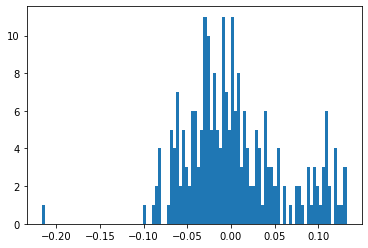

In [13]:
plt.hist(df.fa_m_over_fam,bins=100)
plt.show()

In [70]:
mp = 0
sp = np.nanstd(df.fg)

In [71]:
highmp = mp+sp
highmp
highermp = mp+(2*sp)

In [72]:
lowmp = mp-(0.5*sp)
lowmp
lowermp=mp-(2*sp)

In [17]:
df=pd.read_csv(percentcsv)

In [69]:
mp

-0.0045578046095393135

1162

In [148]:
# want to take IDs and set all to 0 except fg > highmp == 800, fg > higher mp == 1000
# fg < lowmp == 600, fg < lowermp == 500
# then save the tiff
sex_relative = tif.imread(mann)
np.max(sex_relative)

for i in df['ID']:
    if df[df['ID']==i]['fg'].item() >.09:
        sex_relative[sex_relative==i]=1000
    else:
        sex_relative[sex_relative==i]=0

In [149]:
tif.imsave('/home/emilyjanedennis/Desktop/hi_sigma.tif',sex_relative)

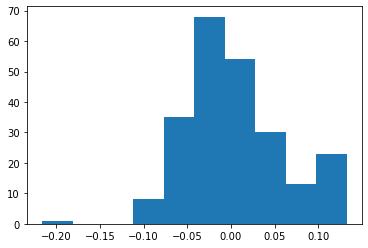

In [104]:
plt.hist(df['fg'])
plt.show()

In [142]:
np.sum(df['fg']<-.06)

24

In [143]:
np.sum(df['fg']>.09)

27

-0.11149420498351735